<a href="https://colab.research.google.com/github/Tara-FD/DIP-project/blob/master/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [101]:
!git clone https://github.com/mohammad2682/Covid19-Dataset

fatal: destination path 'Covid19-Dataset' already exists and is not an empty directory.


In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import VGG16
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

In [103]:
disease_types=['COVID', 'non-COVID']
data_dir = 'Covid19-Dataset/Covid-19-Dataset/train'
train_dir = os.path.join(data_dir)

## Creating Dataframe

In [104]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])

# Randomize the Order
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,non-COVID/Non-Covid (138).png,1,non-COVID
1,COVID/Covid (735).png,0,COVID
2,non-COVID/Non-Covid (679).png,1,non-COVID
3,COVID/Covid (1161).png,0,COVID
4,non-COVID/Non-Covid (707).png,1,non-COVID


## Image Display

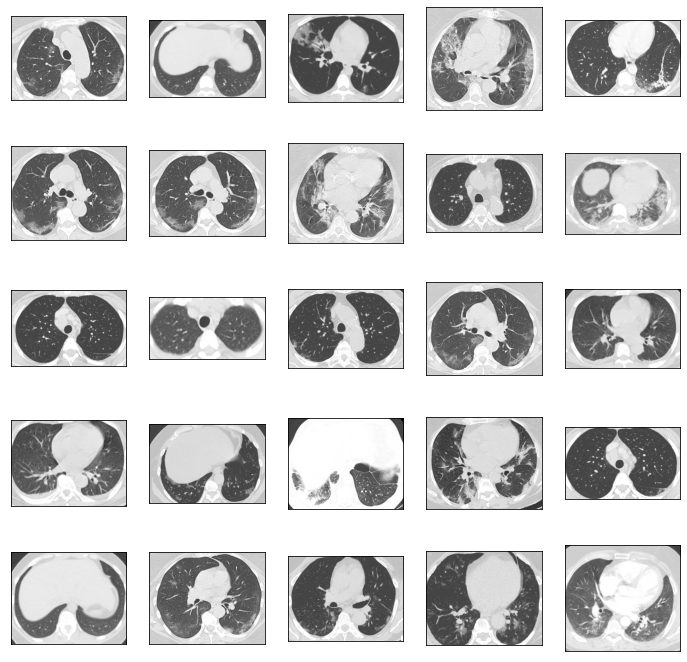

In [105]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
plot_defects('COVID', 5, 5)

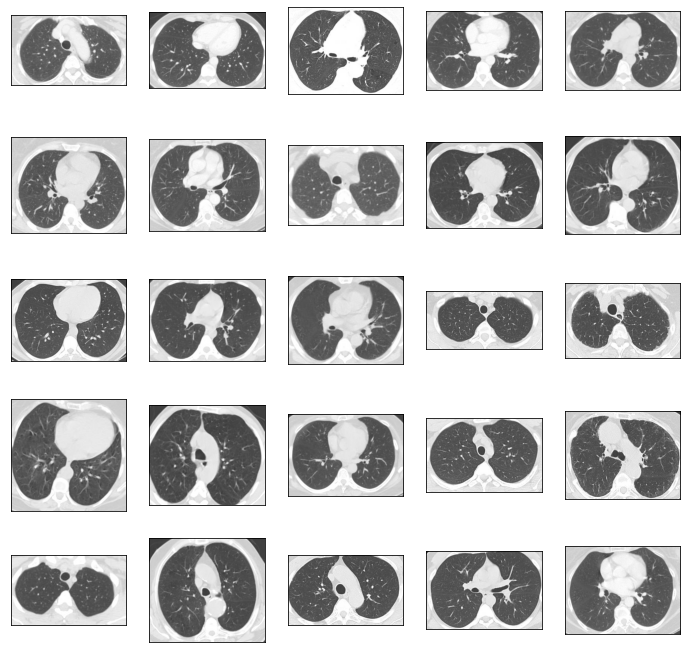

In [106]:
plot_defects('non-COVID', 5, 5)

## Image Read

In [107]:
IMAGE_SIZE = 64
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath))

## Image Resize

In [108]:
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

## Training Images

In [109]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

2000it [00:06, 328.47it/s]


Train Shape: (2000, 64, 64, 3)


## Converting Labels to Categorical

In [110]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=2)

## Train Test Splitting

In [111]:
BATCH_SIZE = 64 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

In [112]:
EPOCHS = 50
SIZE = 64
N_ch = 3


## VGG16 Model

In [117]:
def build_net():
    net = VGG16(weights='imagenet', include_top=False)
    #input layer
    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    #pre-trained network
    x = net(x)
    #classifier
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    #output layer
    output = Dense(2,activation = 'softmax', name='root')(x)
 

    #model
    model = Model(input,output)
    
    #optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    #optimizer = 'adadelta'
    model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
    model.summary()
    
    return model

## Data Augmentation and Fitting Model 

In [118]:
model = build_net()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)
hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 3)         84        
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 512)               0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               1313

## Final Loss and Accuracy

In [119]:
#model = load_model('../output/kaggle/working/model.h5')
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

400/400 [==============================] - 0s 728us/step
Final Loss: 0.3392292793467641, Final Accuracy: 0.8774999976158142


## Confusion Matrix

Text(0.5, 145.31999999999996, 'Predicted')

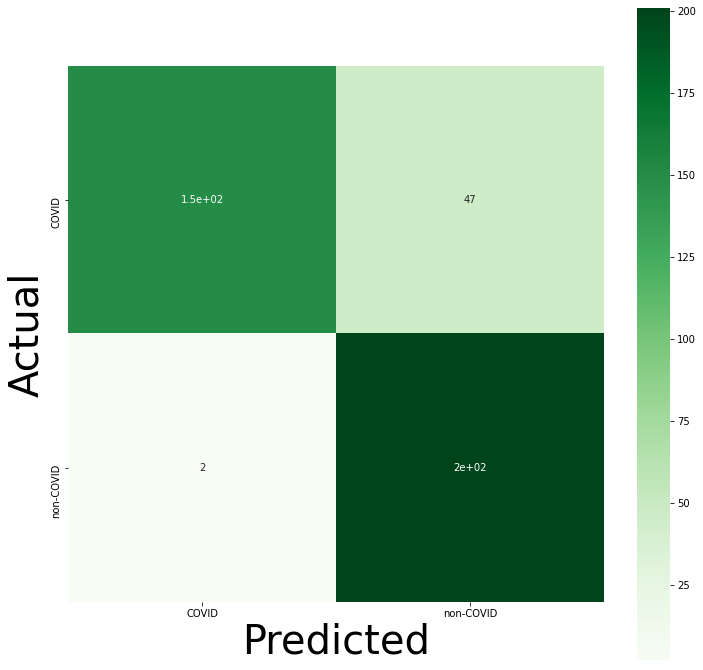

In [120]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

## Accuracy and Loss Curve

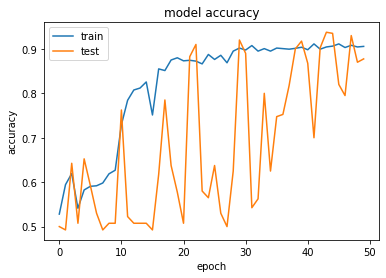

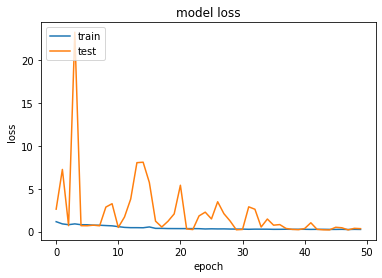

In [121]:
# accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [122]:
yhat_probs = model.predict(X_val)

yhat_classes = np.round(model.predict(X_val))

In [123]:
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]
Y_val2 = Y_val[:,0]

## Evaluation

In [124]:
accuracy = accuracy_score(Y_val2, yhat_classes)
print('Accuracy: %f' % accuracy)

precision = precision_score(Y_val2, yhat_classes)
print('Precision: %f' % precision)

recall = recall_score(Y_val2, yhat_classes)
print('Recall: %f' % recall)

f1 = f1_score(Y_val2, yhat_classes)
print('F1 score: %f' % f1)

Accuracy: 0.877500
Precision: 0.986842
Recall: 0.761421
F1 score: 0.859599
